In [44]:
from bettools import get_data, generate_seasons, calculate_poisson_match_outcomes, calculate_ev_from_odds
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.options.mode.chained_assignment = None 

leagues = ['E0','E1','E2','E3']#'S0','SC0','SC1','SC2','SC3','D1','D2','I1','I2','SP1','SP2','F1','F2','N1','B1','P1','T1','G1']

season_list = generate_seasons(2015, 2024)

df_ls = get_data(season_list, leagues)

In [60]:
main_df = pd.concat(df_ls)

home_games = main_df[['Date', 'HomeTeam', 'FTHG']].rename(columns={'HomeTeam': 'Team', 'FTHG': 'Goals'})

away_games = main_df[['Date', 'AwayTeam', 'FTAG']].rename(columns={'AwayTeam': 'Team', 'FTAG': 'Goals'})

all_games = pd.concat([home_games, away_games], ignore_index=True)

all_games.sort_values(['Team', 'Date'], inplace=True)

all_games['RollingMeanGoals'] = all_games.groupby('Team')['Goals'].transform(lambda x: x.shift().rolling(window=50).mean())

main_df = main_df.merge(all_games[['Date', 'Team', 'RollingMeanGoals']], left_on=['Date', 'HomeTeam'], right_on=['Date', 'Team'], how='left').rename(columns={'RollingMeanGoals': 'RollingMeanHomeGoals'}).drop('Team', axis=1)


main_df = main_df.merge(all_games[['Date', 'Team', 'RollingMeanGoals']], left_on=['Date', 'AwayTeam'], right_on=['Date', 'Team'], how='left').rename(columns={'RollingMeanGoals': 'RollingMeanAwayGoals'}).drop('Team', axis=1)

main_df['goal_loss'] = (main_df['RollingMeanHomeGoals'] - main_df['FTHG'])*(main_df['RollingMeanHomeGoals'] - main_df['FTHG']) + (main_df['RollingMeanAwayGoals'] - main_df['FTAG'])*(main_df['RollingMeanAwayGoals'] - main_df['FTAG'])

main_df['goal_loss'].sum()

40405.0376

In [61]:
results = main_df.apply(lambda x: calculate_poisson_match_outcomes(x['RollingMeanHomeGoals'], x['RollingMeanAwayGoals']), axis=1)

main_df['home_win_prob'], main_df['draw_prob'], main_df['away_win_prob'] = zip(*results)

main_df

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,PSH,PSD,PSA,home_max_odds,away_max_odds,RollingMeanHomeGoals,RollingMeanAwayGoals,goal_loss,home_win_prob,draw_prob,away_win_prob
0,E0,2015-08-08,Bournemouth,Aston Villa,0.0,1.0,1.95,3.65,4.27,2.10,4.27,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2015-08-08,Chelsea,Swansea,2.0,2.0,1.39,4.92,10.39,1.40,11.00,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2015-08-08,Everton,Watford,2.0,2.0,1.70,3.95,5.62,1.73,5.62,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,2015-08-08,Leicester,Sunderland,4.0,2.0,1.99,3.48,4.34,2.00,4.34,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,2015-08-08,Man United,Tottenham,1.0,0.0,1.65,4.09,5.90,1.67,6.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17666,E3,2024-03-12,Swindon,Accrington,1.0,2.0,1.85,4.07,4.03,1.85,4.03,1.60,1.18,1.0324,0.471096,0.247527,0.281376
17667,E3,2024-03-12,Tranmere,Mansfield,2.0,1.0,4.01,3.76,1.93,4.20,1.93,1.34,1.86,1.1752,0.276923,0.226216,0.496857
17668,E3,2024-03-12,Walsall,Barrow,1.0,1.0,2.38,3.17,3.35,2.38,3.35,1.32,1.28,0.1808,0.377445,0.263851,0.358704
17669,E3,2024-03-12,Wrexham,Harrogate,0.0,0.0,1.34,5.57,8.73,1.34,8.73,NaN,1.30,NaN,NaN,NaN,NaN


<Axes: >

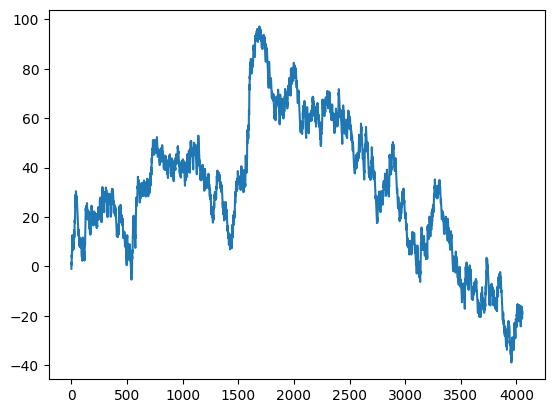

In [68]:
main_df['home_ev'] = main_df.apply(lambda x: calculate_ev_from_odds(x['home_max_odds'], x['home_win_prob']), axis=1)
main_df['away_ev'] = main_df.apply(lambda x: calculate_ev_from_odds(x['away_max_odds'], x['away_win_prob']), axis=1)

HOME_MIN_THRESH = 0
HOME_MAX_THRESH = 1

home_bet_df = main_df[(main_df['home_ev']>HOME_MIN_THRESH)&(main_df['home_ev']<HOME_MAX_THRESH)]
home_bet_df.reset_index(inplace=True, drop=True)
home_bet_df['profit'] = np.where(home_bet_df['FTHG']>home_bet_df['FTAG'], home_bet_df['home_max_odds']-1, -1)
home_bet_df['c_profit'] = home_bet_df['profit'].cumsum()
home_bet_df['c_profit'].plot()

In [59]:
for max_period in range(2,50):
    main_df = pd.concat(df_ls)
    
    home_games = main_df[['Date', 'HomeTeam', 'FTHG']].rename(columns={'HomeTeam': 'Team', 'FTHG': 'Goals'})
    
    away_games = main_df[['Date', 'AwayTeam', 'FTAG']].rename(columns={'AwayTeam': 'Team', 'FTAG': 'Goals'})
    
    all_games = pd.concat([home_games, away_games], ignore_index=True)
    
    all_games.sort_values(['Team', 'Date'], inplace=True)
    
    all_games['RollingMeanGoals'] = all_games.groupby('Team')['Goals'].transform(lambda x: x.shift().rolling(window=max_period).mean())
    
    main_df = main_df.merge(all_games[['Date', 'Team', 'RollingMeanGoals']], left_on=['Date', 'HomeTeam'], right_on=['Date', 'Team'], how='left').rename(columns={'RollingMeanGoals': 'RollingMeanHomeGoals'}).drop('Team', axis=1)
    
    
    main_df = main_df.merge(all_games[['Date', 'Team', 'RollingMeanGoals']], left_on=['Date', 'AwayTeam'], right_on=['Date', 'Team'], how='left').rename(columns={'RollingMeanGoals': 'RollingMeanAwayGoals'}).drop('Team', axis=1)
    
    main_df['goal_loss'] = (main_df['RollingMeanHomeGoals'] - main_df['FTHG'])*(main_df['RollingMeanHomeGoals'] - main_df['FTHG']) + (main_df['RollingMeanAwayGoals'] - main_df['FTAG'])*(main_df['RollingMeanAwayGoals'] - main_df['FTAG'])
    
    goal_loss = (main_df['goal_loss'].sum())/len(main_df.dropna())
    print(f'window: {max_period}, goal loss: {goal_loss}')

window: 2, goal loss: 3.949310995482875
window: 3, goal loss: 3.4976923567285017
window: 4, goal loss: 3.2909495164632743
window: 5, goal loss: 3.153226290862886
window: 6, goal loss: 3.062788982908955
window: 7, goal loss: 3.003450804673538
window: 8, goal loss: 2.9642241190712326
window: 9, goal loss: 2.9312941465511946
window: 10, goal loss: 2.903748972160226
window: 11, goal loss: 2.8734628332963164
window: 12, goal loss: 2.857316287841452
window: 13, goal loss: 2.84543364588831
window: 14, goal loss: 2.8339884694424424
window: 15, goal loss: 2.8215113129381777
window: 16, goal loss: 2.811749662769784
window: 17, goal loss: 2.806605877397294
window: 18, goal loss: 2.7979880494423566
window: 19, goal loss: 2.7881687135379547
window: 20, goal loss: 2.77960405520428
window: 21, goal loss: 2.7747640331204697
window: 22, goal loss: 2.7714962579885
window: 23, goal loss: 2.7674243519349577
window: 24, goal loss: 2.76565938374054
window: 25, goal loss: 2.76337119504644
window: 26, goal lo